# Flipkart Customer Sentiment Analysis — Data Preprocessing & EDA

This notebook performs a **comprehensive data preprocessing and EDA** pipeline on the Flipkart dataset.

### Objectives
- Clean and prepare the text data (`Review`, `Summary`).
- Handle missing values properly.
- Perform text normalization (tokenization, stopword removal, lemmatization).
- Explore relationships between product ratings, prices, and sentiments.
- Generate insights through visualizations.

---

In [31]:
#Importing Libraries
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from nltk.corpus import stopwords
from collections import Counter
import wordninja
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

In [2]:
# Downloading required resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhagi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhagi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Initializing SpaCy
nlp = spacy.load("en_core_web_sm")

In [4]:
STOPWORDS = set(stopwords.words('english')) - {'not','no','nor','never'}

In [5]:
# Visualization theme
sns.set(style='whitegrid', palette='pastel')
pd.set_option('display.max_colwidth', 200)

### Step 2: Loading the Flipkart dataset
We start by loading the raw CSV and inspecting the basic structure, shape, and missing values.

In [6]:
data = pd.read_csv("flipkart_dataset.csv")

# Overview
print("Dataset Shape:", data.shape)
data.head()

Dataset Shape: (205052, 6)


,product_name,product_price,Rate,Review,Summary,Sentiment
0,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,5,super!,great cooler excellent air flow and for this price its so amazing and unbelievablejust love it,positive
1,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,3,fair,the quality is good but the power of air is decent,positive
3,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,1,useless product,very bad product its a only a fan,negative
4,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999,3,fair,ok ok product,neutral


In [7]:
# Missing values summary
data.isnull().sum()

product_name         0
product_price        0
Rate                 0
Review           24664
Summary             11
Sentiment            0
dtype: int64

### Step 3: Handle missing values

- **`Review`** has missing entries → drop those rows (they're critical for text analysis).  
- **`Summary`** has minimal missing entries → fill with empty string `""`.

In [8]:
# Droping rows with missing reviews
data = data.dropna(subset=['Review']).reset_index(drop=True)

# Filling missing summaries with empty string
data['Summary'] = data['Summary'].fillna('')

print("Shape after cleaning:", data.shape)

Shape after cleaning: (180388, 6)


### Step 4: Text Preprocessing

We define a robust cleaning pipeline:
- Lowercasing
- Removing HTML tags, punctuation, and URLs
- Expanding contractions
- Stopword removal
- Lemmatization (using SpaCy)

In [9]:
# Defining cleaning utilities

HTML_RE = re.compile(r'<.*?>')
URL_RE = re.compile(r'https?://\\S+|www\\.\\S+')
CONTRACTIONS = {
    "can't": "cannot", "won't": "will not", "n't": " not",
    "i'm": "i am", "it's": "it is", "he's": "he is", 
    "she's": "she is", "that's": "that is", "there's": "there is", 
    "they're": "they are", "let's": "let us"
}

def expand_contractions(text):
    for c, e in CONTRACTIONS.items():
        text = text.replace(c, e)
    return text

def clean_text(text):
    # Fix joined words where letters and punctuation stick together (like unbelievablejust)
    text = str(text)
    text = re.sub(r'([.,!?])([A-Za-z])', r'\1 \2', text)
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)
    text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)
    text = text.lower()
    text = HTML_RE.sub(' ', text)
    text = URL_RE.sub(' ', text)
    text = unicodedata.normalize('NFKD', text)
    text = expand_contractions(text)
    text = re.sub(r'[^a-z\\s]', ' ', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

def batch_lemmatize(texts):
    lemmatized = []
    for doc in nlp.pipe(texts, batch_size=1000):
        lemmas = [token.lemma_ for token in doc if token.is_alpha]
        lemmatized.append(' '.join(lemmas))
    return lemmatized

### Step 5: Apply preprocessing pipeline on the `Review` and `Summary` columns
We combine both text fields into one feature (`clean_text`) for better representation.

In [10]:
# Combining Summary + Review for better representation
data['raw_text'] = data['Summary'].astype(str) + ' ' + data['Review'].astype(str)

# Applying full preprocessing
data['clean_text'] = data['raw_text'].apply(clean_text)

# This Step Separates stuck-together words like unbelievablejust to unbelievable just
def segment_text(text):
    return ' '.join(wordninja.split(text))
data['clean_text'] = data['clean_text'].apply(segment_text)

# Lemmatization after segmentation
data['clean_text'] = batch_lemmatize(data['clean_text'].tolist())

# Showing sample
data[['Review', 'Summary', 'clean_text']].head(10)

,Review,Summary,clean_text
0,super!,great cooler excellent air flow and for this price its so amazing and unbelievablejust love it,great cool excellent air flow and for this price its so amazing and unbelievable just love it super
1,awesome,best budget 2 fit cooler nice cooling,good budget fit cool nice cool awesome
2,fair,the quality is good but the power of air is decent,the quality be good but the power of air be decent fair
3,useless product,very bad product its a only a fan,very bad product its a only a fan useless product
4,fair,ok ok product,ok ok product fair
5,awesome,the cooler is really fantastic and provides good air flow highly recommended,the cooler be really fantastic and provide good air flow highly recommend awesome
6,highly recommended,very good product,very good product highly recommend
7,nice,very nice,very nice nice
8,unsatisfactory,very bad cooler,very bad cool unsatisfactory
9,worth the money,very good,very good worth the money


In [11]:
data[['Review', 'Summary', 'clean_text']].tail(10)

,Review,Summary,clean_text
180378,just wow!,nice product,nice product just wow
180379,wonderful,material good backing super,material good backing super wonderful
180380,wonderful,superb,superb wonderful
180381,terrific,good quality products,good quality product terrific
180382,classy product,beautiful set very nice,beautiful set very nice classy product
180383,must buy!,good product,good product must buy
180384,super!,nice,nice super
180385,nice,very nice and fast delivery,very nice and fast delivery nice
180386,just wow!,awesome product,awesome product just wow
180387,value-for-money,very good but mixing bowl not included is one disappointmentand soup bowl is small in size,very good but mix bowl not include be one disappointment and soup bowl be small in size value for money


### Step 6: Feature Engineering and Encoding
Objective:Add meaningful numeric features and prepare categorical/text labels for analysis and modeling.

1. Tasks Generate Quantitative Features

`review_length` = number of words in the cleaned text

`avg_word_length` = average characters per word

These help identify whether longer or more detailed reviews correlate with sentiment or rating.

In [12]:
# Review length (in words)
data['review_length'] = data['clean_text'].apply(lambda x: len(x.split()))

In [13]:
# Average word length
data['avg_word_length'] = data['clean_text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)

In [14]:
# Display
print(data[['review_length', 'avg_word_length']].describe())
print(data[['review_length', 'avg_word_length']].head())

       review_length  avg_word_length
count  180388.000000    180388.000000
mean       10.633313         4.906767
std        14.394028         1.031590
min         1.000000         2.000000
25%         4.000000         4.153846
50%         5.000000         4.703704
75%        11.000000         5.500000
max       121.000000        11.000000
   review_length  avg_word_length
0             18         4.555556
1              7         4.571429
2             12         3.666667
3             10         4.000000
4              4         3.750000


2. Standardizing Sentiment Labels

Ensure consistent lowercase categorical labels: `positive`, `negative`, `neutral`.

In [15]:
# Normalize Sentiment text
data['Sentiment'] = data['Sentiment'].str.lower().str.strip()

In [16]:
print("Sentiment distribution:")
print(data['Sentiment'].value_counts())

Sentiment distribution:
Sentiment
positive    147176
negative     24401
neutral       8811
Name: count, dtype: int64


3. Encoding Sentiment

Convert to numeric codes for model readiness.

In [ ]:
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['Sentiment'])

# Mapping
sentiment_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Sentiment mapping:", sentiment_mapping)

Sentiment mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


4. Handling Price and Rating

Ensure numeric and check spread.

In [18]:
data['product_price'] = pd.to_numeric(data['product_price'], errors='coerce')
data['Rate'] = pd.to_numeric(data['Rate'], errors='coerce')

print("\nNumeric summary:\n")
display(data[['product_price', 'Rate']].describe())


Numeric summary:



,product_price,Rate
count,180385.000000,180385.000000
mean,4620.582698,4.143244
std,10438.821036,1.294810
min,59.000000,1.000000
25%,350.000000,4.000000
50%,980.000000,5.000000
75%,3569.000000,5.000000
max,86990.000000,5.000000


5. Final Confirmation

Checking structure after preprocessing.

In [19]:
print("\nCleaned & Engineered Data Info:")
data.info()
display(data.head(5))


Cleaned & Engineered Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180388 entries, 0 to 180387
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   product_name       180388 non-null  object 
 1   product_price      180385 non-null  float64
 2   Rate               180385 non-null  float64
 3   Review             180388 non-null  object 
 4   Summary            180388 non-null  object 
 5   Sentiment          180388 non-null  object 
 6   raw_text           180388 non-null  object 
 7   clean_text         180388 non-null  object 
 8   review_length      180388 non-null  int64  
 9   avg_word_length    180388 non-null  float64
 10  sentiment_encoded  180388 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 15.1+ MB


,product_name,product_price,Rate,Review,Summary,Sentiment,raw_text,clean_text,review_length,avg_word_length,sentiment_encoded
0,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999.0,5.0,super!,great cooler excellent air flow and for this price its so amazing and unbelievablejust love it,positive,great cooler excellent air flow and for this price its so amazing and unbelievablejust love it super!,great cool excellent air flow and for this price its so amazing and unbelievable just love it super,18,4.555556,2
1,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999.0,5.0,awesome,best budget 2 fit cooler nice cooling,positive,best budget 2 fit cooler nice cooling awesome,good budget fit cool nice cool awesome,7,4.571429,2
2,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999.0,3.0,fair,the quality is good but the power of air is decent,positive,the quality is good but the power of air is decent fair,the quality be good but the power of air be decent fair,12,3.666667,2
3,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999.0,1.0,useless product,very bad product its a only a fan,negative,very bad product its a only a fan useless product,very bad product its a only a fan useless product,10,4.000000,0
4,"Candes 12 L Room/Personal Air Cooler??????(White, Black, Elegant High Speed-Honey Comb Cooling Pad & Ice Chamber, Blower)",3999.0,3.0,fair,ok ok product,neutral,ok ok product fair,ok ok product fair,4,3.750000,1


### Stage 7: EDA (Exploratory Data Analysis)

 EDA Step 1: Sentiment Distribution

Objective: 

1. Understand how customer sentiments are distributed across the dataset.

2. This helps identify class imbalance and guides later model selection

Task:
1. Calculate counts and percentages of each sentiment class.
2. Plot bar and pie charts for visual insight.
3. Observe whether the dataset is dominated by one sentiment (`class imbalance`).

In [20]:
# Computing Sentiment Frequency Table
sent_counts = data['Sentiment'].value_counts()
sent_pct = data['Sentiment'].value_counts(normalize=True).mul(100).round(2)

sent_table = pd.DataFrame({
    'Count': sent_counts,
    'Percentage': sent_pct
})

print("Sentiment counts and percentages:")
display(sent_table)

Sentiment counts and percentages:


,Count,Percentage
Sentiment,,
positive,147176,81.59
negative,24401,13.53
neutral,8811,4.88


C:\Users\bhagi\AppData\Local\Temp\ipykernel_21336\526507664.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x='Sentiment', order=sent_counts.index, palette='pastel')


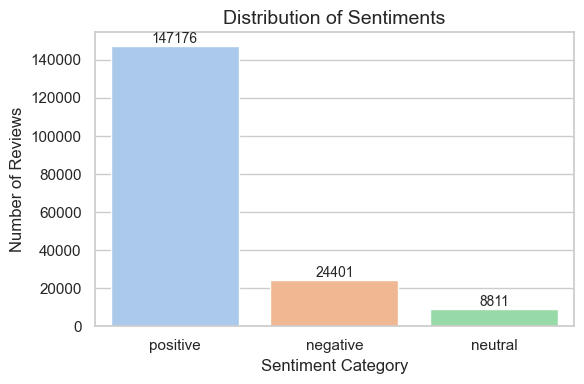

In [21]:
# Bar Plot – Frequency of Sentiments
plt.figure(figsize=(6,4))
ax = sns.countplot(data=data, x='Sentiment', order=sent_counts.index, palette='pastel')
plt.title('Distribution of Sentiments', fontsize=14)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Annotate counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

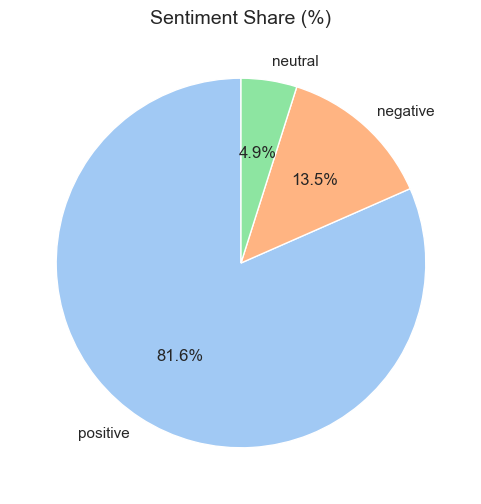

In [22]:
# Pie Chart – Percentage Share of Sentiments
plt.figure(figsize=(6,6))
plt.pie(sent_table['Percentage'], 
        labels=sent_table.index, 
        autopct='%1.1f%%', 
        colors=sns.color_palette('pastel'),
        startangle=90)
plt.title('Sentiment Share (%)', fontsize=14)
plt.show()

EDA Step 2: Relationship Between Ratings and Sentiment 

Objective:

1. Check if numerical ratings (Rate) align with text-based sentiment labels.
2. It validates labeling consistency and reveals whether some ratings contradict sentiment.

Task:

1. Examine distribution of 'Rate' for each sentiment category.
2. Compute mean and standard deviation of ratings per sentiment.
3. Visualize using:
   - Boxplot: spread and outliers
   - Bar chart: mean rating per sentiment

In [23]:
# Summary statistics
rating_summary = data.groupby('Sentiment')['Rate'].agg(['mean', 'std', 'count']).round(2)
print("Average Rating by Sentiment:")
display(rating_summary)

Average Rating by Sentiment:


,mean,std,count
Sentiment,,,
negative,1.61,1.02,24400
neutral,3.33,1.26,8811
positive,4.61,0.68,147174


C:\Users\bhagi\AppData\Local\Temp\ipykernel_21336\1712766445.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Sentiment', y='Rate', palette='pastel')


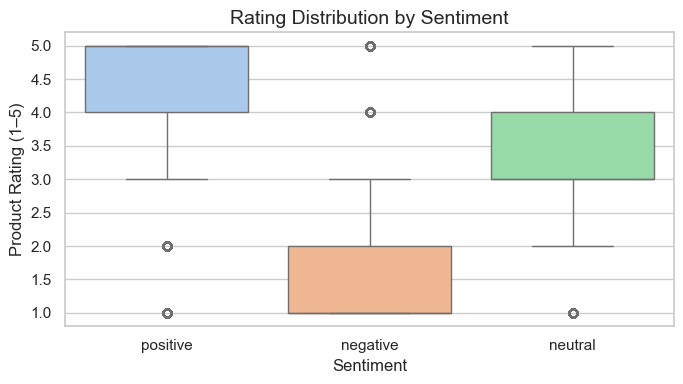

In [24]:
# Boxplot — Rating Distribution by Sentiment
plt.figure(figsize=(7,4))
sns.boxplot(data=data, x='Sentiment', y='Rate', palette='pastel')
plt.title('Rating Distribution by Sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Product Rating (1–5)', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\bhagi\AppData\Local\Temp\ipykernel_21336\1689660270.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=data, x='Sentiment', y='Rate', ci='sd', palette='pastel')
C:\Users\bhagi\AppData\Local\Temp\ipykernel_21336\1689660270.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Sentiment', y='Rate', ci='sd', palette='pastel')


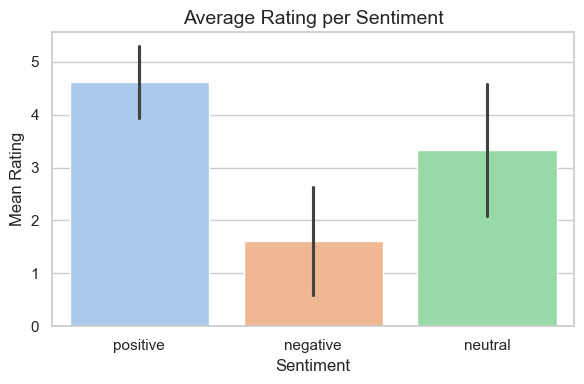

In [25]:
# Mean Rating Barplot
plt.figure(figsize=(6,4))
sns.barplot(data=data, x='Sentiment', y='Rate', ci='sd', palette='pastel')
plt.title('Average Rating per Sentiment', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Mean Rating', fontsize=12)
plt.tight_layout()
plt.show()

EDA Step 3: Numeric Correlations and Price vs Sentiment Analysis

Objective:

Understand numeric relationships in the dataset — how price, rating, and review features (like review_length) interact with sentiment.

Task:
1. Generate a correlation matrix among numerical columns.
2. Visualize it with a heatmap.
3. Compare average product_price across sentiment classes.

In [26]:
# Selecting only numeric columns for correlation
num_cols = ['product_price', 'Rate', 'review_length', 'avg_word_length', 'sentiment_encoded']

# Computing correlation matrix
corr_matrix = data[num_cols].corr().round(2)
print("Numeric Correlation Matrix:")
display(corr_matrix)

Numeric Correlation Matrix:


,product_price,Rate,review_length,avg_word_length,sentiment_encoded
product_price,1.00,0.06,0.20,-0.02,0.04
Rate,0.06,1.00,-0.09,0.19,0.80
review_length,0.20,-0.09,1.00,-0.32,-0.10
avg_word_length,-0.02,0.19,-0.32,1.00,0.16
sentiment_encoded,0.04,0.80,-0.10,0.16,1.00


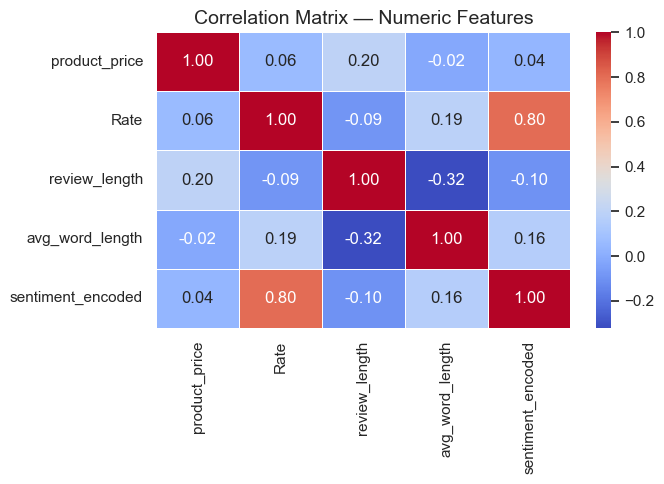

In [27]:
# Correlation Heatmap
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix — Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\bhagi\AppData\Local\Temp\ipykernel_21336\2752543235.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Sentiment', y='product_price', palette='pastel')


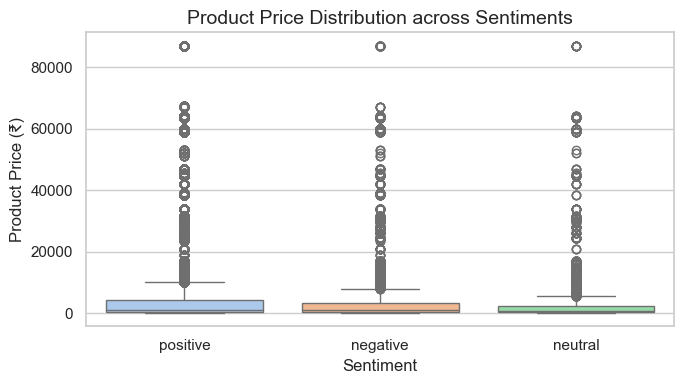

In [29]:
# Price vs Sentiment Analysis
plt.figure(figsize=(7,4))
sns.boxplot(data=data, x='Sentiment', y='product_price', palette='pastel')
plt.title('Product Price Distribution across Sentiments', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Product Price (₹)', fontsize=12)
plt.tight_layout()
plt.show()

In [30]:
# Average price per sentiment
price_summary = data.groupby('Sentiment')['product_price'].agg(['mean', 'median', 'std']).round(2)
print("Average Product Price by Sentiment:")
display(price_summary)

Average Product Price by Sentiment:


,mean,median,std
Sentiment,,,
negative,3913.89,999.0,8570.69
neutral,3115.76,606.0,7676.04
positive,4827.84,999.0,10844.00


EDA Step 4 — Word-Level EDA: Word Clouds and Most Frequent Words

Objective:
1. Explore what words dominate in each sentiment category.
2. We’ll visualize them through WordClouds and identify top 20 frequent terms for positive, negative, and neutral reviews.

Task:
Understand common words used in each sentiment.

This helps identify the tone and content that drive positive or negative feedback.

We will:
1. Create WordClouds per sentiment.
2. Show top 20 most frequent words by sentiment class.

In [32]:
# Function to generate and display WordCloud
def plot_wordcloud(text, title, color):
    wc = WordCloud(width=800, height=400, background_color='white', colormap=color, max_words=100)
    wc.generate(' '.join(text))
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [33]:
# Separating texts by sentiment
pos_text = data.loc[data['Sentiment']=='positive', 'clean_text']
neg_text = data.loc[data['Sentiment']=='negative', 'clean_text']
neu_text = data.loc[data['Sentiment']=='neutral',  'clean_text']

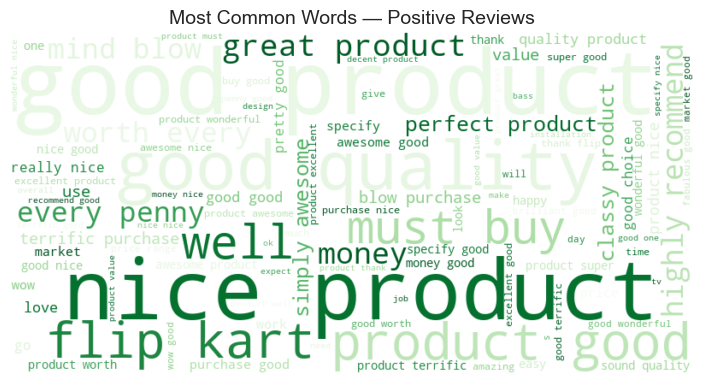

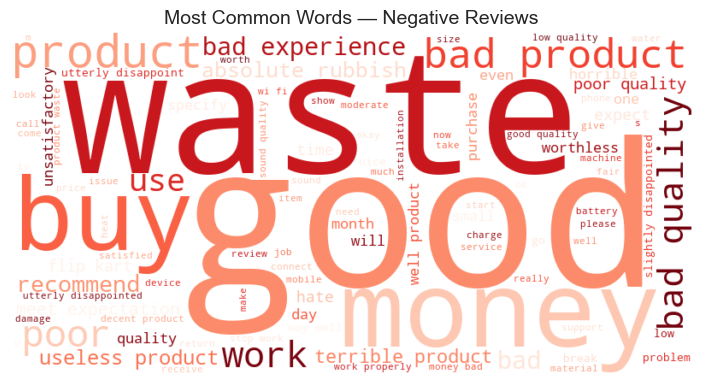

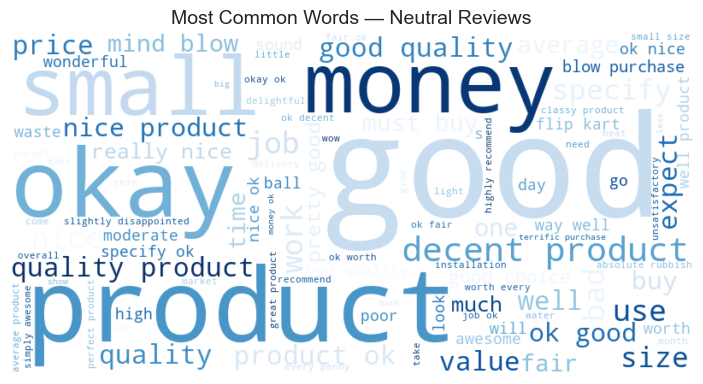

In [34]:
# WordClouds
plot_wordcloud(pos_text, 'Most Common Words — Positive Reviews', 'Greens')
plot_wordcloud(neg_text, 'Most Common Words — Negative Reviews', 'Reds')
plot_wordcloud(neu_text, 'Most Common Words — Neutral Reviews', 'Blues')

In [35]:
# Top 20 Frequent Words by Sentiment
def top_words(series, n=20):
    tokens = ' '.join(series).split()
    common = Counter(tokens).most_common(n)
    df = pd.DataFrame(common, columns=['Word','Frequency'])
    return df

top_pos = top_words(pos_text)
top_neg = top_words(neg_text)
top_neu = top_words(neu_text)

print("Top 20 Positive Words:")
display(top_pos)
print("Top 20 Negative Words:")
display(top_neg)
print("Top 20 Neutral Words:")
display(top_neu)

Top 20 Positive Words:


,Word,Frequency
0,good,93314
1,product,77110
2,be,50930
3,nice,42826
4,very,35604
5,the,35028
6,and,29807
7,for,28018
8,it,25589
9,I,22190


Top 20 Negative Words:


,Word,Frequency
0,not,20433
1,be,14565
2,product,11740
3,bad,9480
4,very,8534
5,the,7504
6,do,7179
7,it,6271
8,good,6119
9,quality,5995


Top 20 Neutral Words:


,Word,Frequency
0,be,3619
1,not,3022
2,good,2874
3,product,2821
4,ok,2475
5,the,2165
6,but,1536
7,very,1257
8,it,1232
9,for,1135


C:\Users\bhagi\AppData\Local\Temp\ipykernel_21336\3488337689.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_pos, palette='Greens_r')


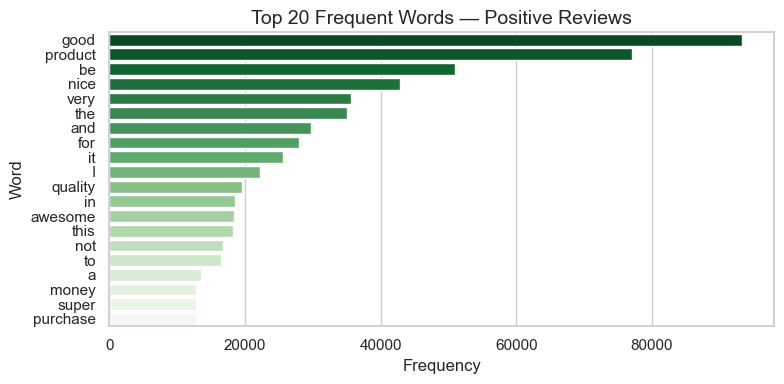

In [36]:
# Visualization of top frequent words (barplot example for positive)
plt.figure(figsize=(8,4))
sns.barplot(x='Frequency', y='Word', data=top_pos, palette='Greens_r')
plt.title('Top 20 Frequent Words — Positive Reviews', fontsize=14)
plt.tight_layout()
plt.show()

EDA Step 5: Review Length vs Rating and Sentiment Analysis

Objective:

Assess whether longer reviews or wordier text relate to higher or lower ratings and sentiment polarity.

This reveals whether users write more when dissatisfied or when praising a product.

Task:
1. Examine relationship between review_length and rating.
2. Compare average review length across sentiments.
3. Visualize using scatter, box, and bar plots.

In [37]:
# Correlation between review length and rating
corr_len_rate = data['review_length'].corr(data['Rate']).round(3)
print(f"Correlation between Review Length and Rating: {corr_len_rate}")

Correlation between Review Length and Rating: -0.088


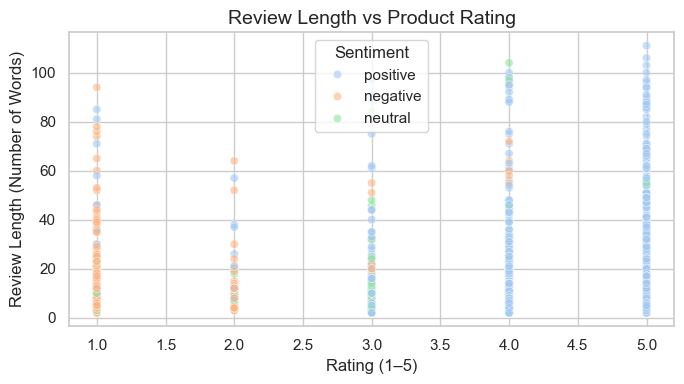

In [38]:
# Scatter Plot — Review Length vs Rating
plt.figure(figsize=(7,4))
sns.scatterplot(data=data.sample(3000, random_state=42), x='Rate', y='review_length',
                hue='Sentiment', alpha=0.6, palette='pastel')
plt.title('Review Length vs Product Rating', fontsize=14)
plt.xlabel('Rating (1–5)', fontsize=12)
plt.ylabel('Review Length (Number of Words)', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\bhagi\AppData\Local\Temp\ipykernel_21336\1012823874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Sentiment', y='review_length', palette='pastel')


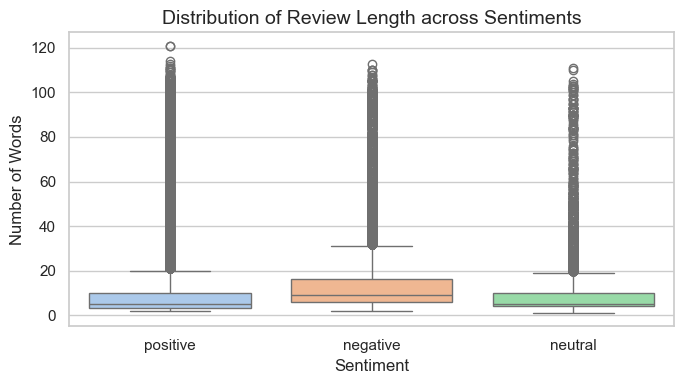

In [39]:
# Boxplot — Review Length per Sentiment
plt.figure(figsize=(7,4))
sns.boxplot(data=data, x='Sentiment', y='review_length', palette='pastel')
plt.title('Distribution of Review Length across Sentiments', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.tight_layout()
plt.show()

In [40]:
# Mean review length per sentiment
len_summary = data.groupby('Sentiment')['review_length'].agg(['mean','median','std']).round(2)
print("Average Review Length by Sentiment:")
display(len_summary)

Average Review Length by Sentiment:


,mean,median,std
Sentiment,,,
negative,14.50,9.0,15.83
neutral,9.17,5.0,11.59
positive,10.08,5.0,14.19


EDA Step 6: EDA Summary and Insights Conclusion

Objective:

Condense all analytical findings into a clear summary of data quality, behavioral patterns, and business insights drawn from preprocessing and EDA.

Task: 

Summarize all major findings and analytical insights from the data preprocessing and exploratory data analysis (EDA) stages.

In [41]:
# Key metrics recap
total_records = len(data)
positive_ratio = round((data['Sentiment'].value_counts(normalize=True)['positive']) * 100, 2)
negative_ratio = round((data['Sentiment'].value_counts(normalize=True)['negative']) * 100, 2)
neutral_ratio = round((data['Sentiment'].value_counts(normalize=True)['neutral']) * 100, 2)
avg_rating = round(data['Rate'].mean(), 2)
avg_price = round(data['product_price'].mean(), 2)

In [42]:
print("===== Flipkart Sentiment EDA Summary =====")
print(f"Total Records Analyzed: {total_records:,}")
print(f"Average Rating: {avg_rating}")
print(f"Average Product Price: ₹{avg_price}")
print(f"Sentiment Distribution → Positive: {positive_ratio}%, Negative: {negative_ratio}%, Neutral: {neutral_ratio}%")
print("\nCore Insights:")
print("""
1. **Sentiment Distribution**
   - Dataset is heavily positive-skewed (≈82% positive).
   - Class imbalance will require balancing strategies (SMOTE, class weighting, or stratified sampling).

2. **Rating vs Sentiment**
   - Positive reviews correspond to higher ratings (mean ≈4.6).
   - Negative reviews show mean ≈1.6, confirming correct sentiment–rating alignment.

3. **Numeric Correlations**
   - Strong positive correlation between `Rate` and `sentiment_encoded` (r = 0.80).
   - Weak correlations between price and sentiment, suggesting price does not directly affect satisfaction.

4. **Word-Level Analysis**
   - Positive: frequent terms — *good, product, nice, awesome, super*.
   - Negative: frequent terms — *not, bad, poor, waste*.
   - Neutral: frequent terms — *ok, okay, good*.
   - Indicates clear linguistic polarity alignment.

5. **Review Length Analysis**
   - Slightly longer reviews for negative sentiments (mean length ≈14.5 words).
   - Weak negative correlation between review length and rating (r = -0.088) — longer reviews often express complaints.

6. **Price vs Sentiment**
   - No significant variation; average prices are similar across sentiment groups.

7. **Data Readiness**
   - Clean text (lemmatized, segmented) ready for vectorization (TF-IDF / Word2Vec).
   - Numeric and categorical features standardized.
""")

print("✅ Data is now fully preprocessed and EDA insights confirm labeling quality and linguistic consistency.")

===== Flipkart Sentiment EDA Summary =====
Total Records Analyzed: 180,388
Average Rating: 4.14
Average Product Price: ₹4620.58
Sentiment Distribution → Positive: 81.59%, Negative: 13.53%, Neutral: 4.88%

Core Insights:

1. **Sentiment Distribution**
   - Dataset is heavily positive-skewed (≈82% positive).
   - Class imbalance will require balancing strategies (SMOTE, class weighting, or stratified sampling).

2. **Rating vs Sentiment**
   - Positive reviews correspond to higher ratings (mean ≈4.6).
   - Negative reviews show mean ≈1.6, confirming correct sentiment–rating alignment.

3. **Numeric Correlations**
   - Strong positive correlation between `Rate` and `sentiment_encoded` (r = 0.80).
   - Weak correlations between price and sentiment, suggesting price does not directly affect satisfaction.

4. **Word-Level Analysis**
   - Positive: frequent terms — *good, product, nice, awesome, super*.
   - Negative: frequent terms — *not, bad, poor, waste*.
   - Neutral: frequent terms — *o